In [210]:
import os

import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

import shutil

import re

import pywt
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
%matplotlib inline


face_cascade = cv2.CascadeClassifier(r'C:\Users\spark\PycharmProjects\image_face_recognition\haars\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'C:\Users\spark\PycharmProjects\image_face_recognition\haars\haarcascade_eye.xml')

In [211]:
def change_file_name(folder_path, name:str):
    """
    Change file names to more readable ^_^
    :param folder_path: path to dictionary with images
    :param name: new file\s name\s
    """
    # Переходим в папку с фотографиями
    os.chdir(folder_path)

    # Получаем список файлов в папке
    file_list = os.listdir()

    # Расширения файлов, которые вы хотите обрабатывать
    extensions = ['.jpg', '.jpeg', '.png']

    # Проходимся по каждому файлу и проверяем расширение
    for index, file_name in enumerate(file_list):
        # Получаем расширение файла
        file_ext = os.path.splitext(file_name)[1].lower()  # Получаем расширение и приводим его к нижнему регистру

        # Проверяем, что расширение файла находится в списке разрешенных
        if file_ext in extensions:
            # Новое имя файла (можно настроить согласно вашим требованиям)
            new_name = f"{name}_{index}{file_ext}"  # Пример нового имени: photo_0.jpg, photo_1.png и т.д.

            # Полный путь к текущему файлу
            current_path = os.path.join(folder_path, file_name)

            # Полный путь к новому файлу
            new_path = os.path.join(folder_path, new_name)
            try:
                # Переименовываем файл
                os.rename(current_path, new_path)
                print(f"Файл {file_name} переименован в {new_name}")
            except FileExistsError:
                new_name = f"test_photo_{index+1}{file_ext}"
                print(f"Файл {file_name} переименован в {new_name}")
        else:
            print(f"Файл {file_name} имеет неподдерживаемое расширение и будет проигнорирован.")

In [212]:
def crop_image(image_path):
    # Читаем картинку
    img = cv2.imread(image_path)

    # Приводим её к серому цвету
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Обнаруживаем лицо
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Если находим пару глаз на лице, то вносим такое фото
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [213]:
#cropped_image = crop_image(r'C:\Users\spark\PycharmProjects\image_face_recognition\data\test_images\test_photo0.jpg')

#if cropped_image is False:
#    print(f"У изображения _ не было найденно лицо")
#else:
#    plt.imshow(cropped_image)

#### Находим имена папок по заданому пути, и записываем их в список

In [214]:
path_to_images = "C:/Users/spark/PycharmProjects/image_face_recognition/data"
path_to_cropped = "C:/Users/spark/PycharmProjects/image_face_recognition/data/cropped"

In [215]:
name_of_folders_path = []
for folder in os.scandir(path_to_images):
    if folder.is_dir():
        name_of_folders_path.append(folder.path)

#### Создаем или находим папку cropped для обрезанных фото

In [216]:
if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped) # Удаление папки если она есть
os.mkdir(path_to_cropped) # Создание заново

In [217]:
cropped_person_path = {}
cropped_images_dirs = []

counter_face_miss = 0
pictures = 0
# change_file_name(f"{path_to_images}/{person_name}", person_name)

for folder_name_path in name_of_folders_path:
    # Получаем имя папки из пути
    person_name = folder_name_path.split("\\")[-1]
    # Убираем тестовую папку
    if person_name == "test_images" or person_name == "cropped":
        continue

    print(person_name)

    # Наполняем словарь с ключом = имя, значение = путь
    cropped_person_path[person_name] = []

    for image in os.scandir(folder_name_path + "/"):
        pictures += 1
        roi_cropped = crop_image(image.path)
        if roi_cropped is None:
            # print(f"В Папке с именем {person_name}. У изображения {image} не было найдено лицо")
            counter_face_miss += 1
            continue
        else:
            cropped_folder_path = path_to_cropped + "/" + person_name
            if not os.path.exists(cropped_folder_path):
                os.makedirs(cropped_folder_path)
                cropped_images_dirs.append(cropped_folder_path)

            image_name = image.name
            cropped_file_path = os.path.join(cropped_folder_path, image_name)

            cv2.imwrite(cropped_file_path, roi_cropped)
            cropped_person_path[person_name].append(cropped_file_path)

print(f"\nПотерянно лиц: {counter_face_miss}")
print(f"Всего картинок: {pictures}\n\nЗагружено: {pictures - counter_face_miss}")

andrey_bond
dina_samatova
elvira_lukhmenko
kyrrylo_chistik
liza_dorik
mykyta_khambur

Потерянно лиц: 95
Всего картинок: 238

Загружено: 143


In [218]:
# Создаем one-hot словарь из названий папок (по совместительству имен людей)
one_hot_class = {}

for number, person in enumerate(cropped_person_path.keys()):
    one_hot_class[person] = number
one_hot_class

{'andrey_bond': 0,
 'dina_samatova': 1,
 'elvira_lukhmenko': 2,
 'kyrrylo_chistik': 3,
 'liza_dorik': 4,
 'mykyta_khambur': 5}

In [219]:
def w2d(im_array, mode='haar', level=1):
    """
    Функция выделяет черты лица (контрасты)
    :param im_array: картинка прочитаная cv.imread
    :param mode: применяет вейвлетное преобразование в указанном режиме
    :param level: и заданном уровне
    :return:
    """
    #imArray = img
    #Datatype conversions
    #convert to grayscale
    im_array = cv2.cvtColor( im_array,cv2.COLOR_RGB2GRAY )
    #convert to float
    im_array =  np.float32(im_array)
    im_array /= 255
    # compute coefficients
    coefficients = pywt.wavedec2(im_array, mode, level=level)

    #Process Coefficients
    coefficients_h = list(coefficients)
    coefficients_h[0] *= 0

    # reconstruction
    im_array_h=pywt.waverec2(coefficients_h, mode)
    im_array_h *= 255
    im_array_h =  np.uint8(im_array_h)

    return im_array_h

In [220]:
# Создаем обучающий массив данных (фичи) и ответы к нему. X - представляет собой комбинацию из
X, y = [], []

# Берем имя человека и путь к картинке
for person, path_to_training_images in cropped_person_path.items():

    # Из списка всех картинок, берем одну
    for training_image in path_to_training_images:

        # Читаем картинку с помощью open cv
        img = cv2.imread(training_image)

        # Приводим к одному размеру
        scaled_image = cv2.resize(img, (32, 32))

        # Проводим через функцию которая выделяет черты
        img_har = w2d(img,'db1',5)

        # Проводим к одному размеру после преобразования
        scaled_img_har = cv2.resize(img_har, (32, 32))

        # объедением цветное фото с черно-белым
        combined_img = np.vstack((scaled_image.reshape(32 * 32 * 3, 1), scaled_img_har.reshape(32 * 32, 1)))

        # Записываем в обучающую выборку изображения (массив цветов) и цифру соответствующего человека
        X.append(combined_img)
        y.append(one_hot_class[person])

In [221]:
# Переводим все данные в float и убеждаемся что их столько же, сколько записанных картинок
X = np.array(X).reshape(len(X),4096).astype(float)
print(f"Всего картинок загружено: {pictures - counter_face_miss}\nРазмеры тестового массива: {X.shape}")

Всего картинок загружено: 143
Размеры тестового массива: (143, 4096)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
# split
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


In [223]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8055555555555556

In [224]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       1.00      1.00      1.00         3
           2       0.88      0.94      0.91        16
           3       0.00      0.00      0.00         1
           4       0.67      0.80      0.73         5
           5       0.83      0.71      0.77         7

    accuracy                           0.81        36
   macro avg       0.65      0.66      0.65        36
weighted avg       0.79      0.81      0.79        36



C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [225]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [226]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [227]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\spark\PycharmProjects\image_face_recognition\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


,model,best_score,best_params
0,svm,0.619048,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.391775,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.571429,{'logisticregression__C': 1}


In [228]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [229]:
scores_info = {}
scores_info[(best_estimators['svm'].score(X_test,y_test))] = "svm"
print(best_estimators['svm'].score(X_test,y_test))

0.6944444444444444


In [230]:
scores_info[(best_estimators['random_forest'].score(X_test,y_test))] = "random_forest"
print(best_estimators['random_forest'].score(X_test,y_test))

0.5833333333333334


In [231]:
scores_info[(best_estimators['logistic_regression'].score(X_test,y_test))] = "logistic_regression"
print(best_estimators['logistic_regression'].score(X_test,y_test))

0.8333333333333334


In [232]:
scores_info

{0.6944444444444444: 'svm',
 0.5833333333333334: 'random_forest',
 0.8333333333333334: 'logistic_regression'}

In [233]:
the_best = max(scores_info.keys())
best_model = scores_info[the_best]

In [234]:
best_clf = best_estimators['svm']

In [235]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 2,  1,  0,  0,  1,  0],
       [ 0,  3,  0,  0,  0,  0],
       [ 3,  1, 12,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  2,  0,  3,  0],
       [ 1,  0,  0,  0,  1,  5]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

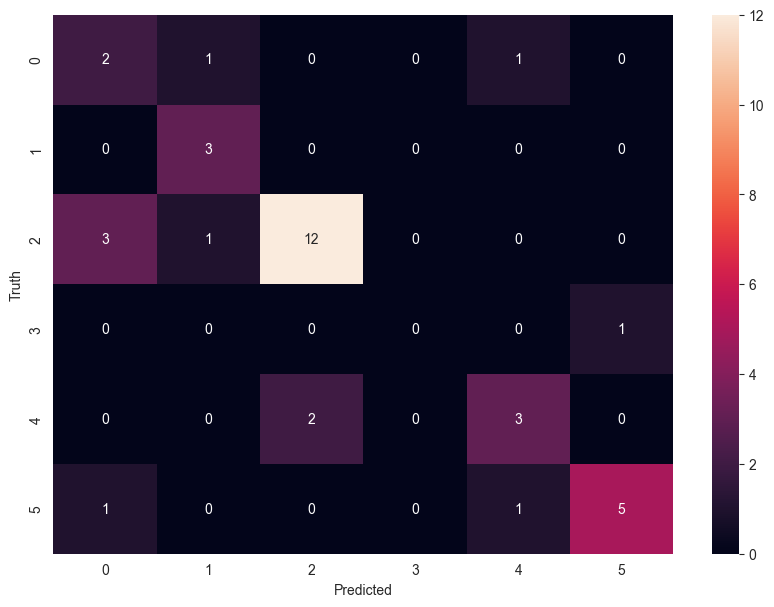

In [236]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [237]:
best_clf = best_estimators[best_model]
cm = confusion_matrix(y_test, best_clf.predict(X_test))

Text(95.72222222222221, 0.5, 'Truth')

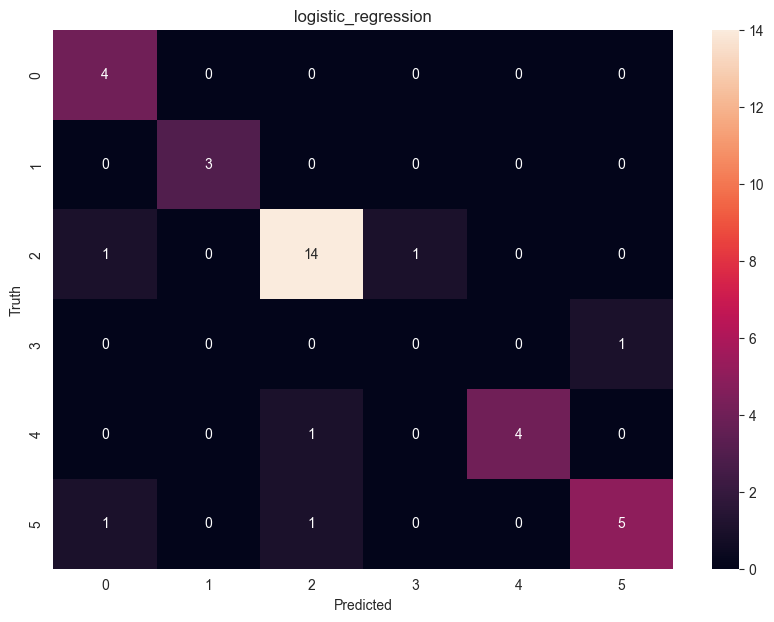

In [238]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.title(best_model)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [239]:
one_hot_class

{'andrey_bond': 0,
 'dina_samatova': 1,
 'elvira_lukhmenko': 2,
 'kyrrylo_chistik': 3,
 'liza_dorik': 4,
 'mykyta_khambur': 5}

In [240]:
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'image_recognition_svm.pkl')

['image_recognition_svm.pkl']

In [241]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(one_hot_class))

In [242]:
"""import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(type(X))
print(type(y))
print(y)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
print(f"aaaaaaaaaaaaa \n\n{X_train}")
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# loss metric and optimizer
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 200
batch_size = 5
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()"""

'import copy\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport tqdm\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import OneHotEncoder\n\n# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors\nX = torch.tensor(X, dtype=torch.float32)\ny = torch.tensor(y, dtype=torch.float32)\n\nprint(type(X))\nprint(type(y))\nprint(y)\n\n# split\nX_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)\nprint(f"aaaaaaaaaaaaa \n\n{X_train}")\nclass Multiclass(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.hidden = nn.Linear(4, 8)\n        self.act = nn.ReLU()\n        self.output = nn.Linear(8, 3)\n\n    def forward(self, x):\n        x = self.act(self.hidden(x))\n        x = self.output(x)\n        return x\n\n# loss metric and optimizer\nmodel = Multiclass()\nloss_fn = nn.CrossEntropyLoss()\noptimizer = optim